TL:DR Devito allows users to build finite difference schemes in python and "compile-down" to optimized C++

Finite difference methods have a long history in quantitative finance.  They are the preferred technique to price and risk manage instruments based on low dimensional probabilistic models that lack analytic solutions.  To implement the finite difference method, one chooses a discretization scheme (or stencil) that approximates the derivatives in the model.  This scheme converts a system of differential equations into a system of algebraic equations that can be solved numerically. 

Naturally, a scheme introduces error into the calculation that is roughly proportional to the order of the discretization.  Higher order schemes decrease the error in the system but are more difficult to implement by hand in compiled numerical code. Most option pricing libraries provide utilities for building common, low-order schemes. For instance, QuantLib provides forward, backward and central difference operators that can be combined to build a finite difference pricing engine for a given model.

A new python library called [Devito](http://www.opesci.org/devito-public) takes a different approach to finite difference model building.  Instead of building a discretization scheme directly in C++, it instead allows users to build an arbitrary scheme in python and "compile" that scheme down to optimized C++.  This code can either be JIT compiled and executed immediately or retained for later execution.

In order to make this approach possible, Devito leverages Sympy, the python-based computer algebra system.  Devito uses Sympy to algebraically manipulate the system of differential equations and generates the equivalent stencil equations used in the numerical implementation.  It then generates optimized C++ code after passing the stencil equations through various optimization algorithms.    

This approach is equivalent to what happens in a compiler.  To wit, "high-level" code is parsed, passed through optimization algorithms and printed down to "low-level" code.  In this example, python is the high level code and C++ is the low level code. 

This approach has several advantages; one, the python implementation is close to the mathematical language; two, the often tedious algebraic manipulations needed to build the stencil is off-loaded to the computer algebra system (Sympy); three, the C++ implementation can be highly optimized of efficient computation.


### Black Scholes Equation

As a first example, let's implement a finite difference solution of the Black Scholes model, the Hello World of quant finance. The Black Scholes PDE for a European option with strike, K, spot, S, volatility $\sigma$, risk free rate, r, expiring at T, is given by

$$
\begin{equation}
\frac{\partial V}{\partial t} + \frac{\sigma^2S^2}{2}\frac{\partial ^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
\end{equation}
$$

with the terminal condition for a Call option given by

$$V(S,T) = \max(S-K,0)$$

This PDE can be solved analytically:


$$V(S,K,t,r, \sigma)=SN(d_1)−Ke^{−rt}N(d_2)$$

 
$$d_1=\frac{\ln\left(\frac{S}{K}\right)+\left(r+0.5\sigma^2\right)T}{\sigma\sqrt{T}}\,\,\,d_2=d_1−\sigma\sqrt{T}$$



In Numpy, this pricing function is

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Black Scholes Formula
def d1(S0, K, r, sigma, t):
    return (np.log(S0/K) + (r + sigma**2 / 2) * t)/(sigma * np.sqrt(t))
 
def d2(S0, K, r, sigma, t):
    return (np.log(S0/K) + (r - sigma**2 / 2) * t)/(sigma * np.sqrt(t))
 
def BlackScholes(S0, K, r, sigma, T):
    return S0 * norm.cdf(d1(S0, K, r, sigma, T)) - K * np.exp(-r*T) * norm.cdf(d2(S0, K, r, sigma, T))


### BS Finite Difference Scheme in Numpy

In order to solve the BS PDE using finite difference techniques, we need to choose a discretization scheme. Keeping things simple, we choose central differences in space and forward differencing in time.  Indexing the spatial dimension with $i$ and the temporal dimension with $n$, Black Scholes PDE  then becomes 

$$
\begin{align}
V_{i}^{n+1} &= V_{i}^n -  \frac{\sigma^2 (i\Delta S)^2 \Delta t}{2\Delta S^2}\left(V_{i+1}^n - 2 V_{i}^n + V_{i-1}^n\right) - r(i\Delta S)\frac{\sigma \Delta t}{2\Delta S}\left(V_{i+1}^n- V_{i-1}^n \right)
+ r \Delta t V_{i}^n \\
& = V_{i}^n - \frac{\sigma^2 (i)^2 \Delta t}{2}\left(V_{i+1}^n - 2 V_{i}^n + V_{i-1}^n\right) - r(i)\frac{\sigma \Delta t}{2}\left(V_{i+1}^n- V_{i-1}^n \right)
+ r \Delta t V_{i}^n 
\end{align}
$$

Let's first implement a Numpy version of the scheme for comparison's sake. The numerical algorithm essentially works as follows 

1. Evaluate the pricing function at the boundary (payoff)
2. Iterate backwards in time, solving the difference equation at each iteration
3. Terminate at t=0 (the evaluation date) to obtain the present value (PV)

In terms of data structures, all we need in order to implement this algorithm is two Numpy array buffers. 

#### A word on spatial boundary conditions

We need to choose spatial boundary conditions on pricing function.  In practice, this means enforcing some conditions on either the pricing function itself or derivatives of the pricing function.  Following [Wilmott Vol 3](https://www.amazon.com/Paul-Wilmott-Quantitative-Finance-Set/dp/0470018704), we choose the following boundary conditions 

1. For $S = 0 \;\; \frac{\partial V}{\partial t}(0,t) - rV(0,t) = 0$


In discrete form this becomes: 
$$V_n^0 = (1 - r \delta t) V_{k-1}^0$$

2. For $S = S_{max}\;\; \frac{\partial^2 V}{\partial S^2}(S,t) = 0$

In discrete form this becomes: 
$$V_n^i = 2V_n^{i-1} - V_n^{i-2}$$

In principle, one can choose different boundary conditions without greatly effecting the computed pricing functions.  For the remaining variables needed to solve the problem we make the following choices

In [4]:
# Some variable declarations needed for numerical implementation
nx = 20    # number of space steps
s = 0.2    # vol
r = 0.05   # interest rate
T = 1      # time to expiry
K = 100    # Strike
dt = (0.9/(s*nx)**2) # time step size
nt = int(T/dt) + 1  # number of time steps
dt = T/nt
dx = 2*K/nx

Defining a Call payoff function and initializing it at the t=T boundary

In [5]:
def payoff(S,K):
    return np.maximum(S-K,0)

v_payoff = np.vectorize(payoff)
v_bs = np.vectorize(BlackScholes)

# Init C at the payoff
S = np.arange(0,(nx+1)*dx,dx)
C = v_payoff(S,K)

Now we can define a diffuse function that carries out the finite difference algorithm. Here we name our pricing function `C` for Call in order to distinguish it from `V` used below in the Devito implementation.

In [6]:
def diffuse(C, nt):
    for n in range(nt): 
        Cn = C.copy()
        delta = (0.5/dx)*(Cn[2:] - Cn[0:-2])
        gamma = (1/(dx**2))*(Cn[2:] - 2*Cn[1:-1] + Cn[0:-2])
        theta = -(0.5*s**2)*np.multiply(np.square(S[1:-1]),gamma) - r*np.multiply(S[1:-1],delta) + r*Cn[1:-1]
        C[1:-1] = Cn[1:-1] - dt*theta
        #spatial bc's
        C[0] = Cn[0]*(1 - r*dt)
        C[nx-1] = 2*C[nx-2] - C[nx-3]


With our implementation in place, let's diffuse the model back 10 time steps. 

In [7]:
diffuse(C, nt=10)

Comparing this to analytic solution to BS gives

In [8]:
C

array([  0.00000000e+00,   6.77083365e-15,   2.47797465e-11,
         1.38986768e-08,   2.31379196e-06,   1.50919507e-04,
         4.48551091e-03,   6.67669285e-02,   5.33585468e-01,
         2.44970519e+00,   7.05423863e+00,   1.43368053e+01,
         2.32467881e+01,   3.28816476e+01,   4.27765661e+01,
         5.27502671e+01,   6.27445527e+01,   7.27434913e+01,
         8.27433082e+01,   9.27431251e+01,   1.00000000e+02])

In [10]:
v_bs(S0=S, K=100, r=r, sigma=s, T=10*dt)

/home/givenskm/anaconda3/envs/devito/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/givenskm/anaconda3/envs/devito/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


array([  0.00000000e+00,   2.13184792e-53,   8.12368101e-27,
         1.49012572e-15,   1.86102962e-09,   8.60357129e-06,
         1.81033147e-03,   5.89084888e-02,   5.84232552e-01,
         2.66791893e+00,   7.33121846e+00,   1.45076224e+01,
         2.33168378e+01,   3.29033374e+01,   4.27809370e+01,
         5.27490737e+01,   6.27415850e+01,   7.27399614e+01,
         8.27396309e+01,   9.27395669e+01,   1.02739555e+02])

Ploting the PV gives reasonable looking results

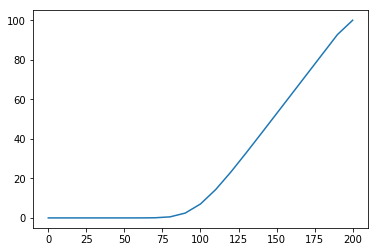

In [11]:
fig, ax = plt.subplots()
ax.plot(S, C)

## Devito Implementation

Now we want to implement the same model in Devito. First, a brief word about the Devito API. (For more info, consult the Devito documentation)  

A key idea in Devito is to present users with a `Function` object that has dual identity, one symbolic and the other numeric.  That is, `Function` objects can be manipulated by Sympy in order to generate the stencil equations. Later, when the finite difference scheme is being numerically solved, `Function` objects hold numerical data in two Numpy array buffers in similar way to how data was stored during the Numpy implementation given above.  This dual approach allows users to implement and solve the finite difference problems in a natural way.  They don't have to implement and reason about separate data structures for the differential equations as well as the numerical implementation.

For our implementation, we first need to declare instances of `Grid`, `Function` and `TimeFunction` (time varying function).  We then define the stencil equation using the `TimeFunction` `V`'s Sympy identity.

In [12]:
from devito import Grid, TimeFunction, Function, Operator
from sympy import Eq, solve

In [13]:
# Initialize `u` for space order 2
grid = Grid(shape=(nx+1,), extent=(200.,))
V = TimeFunction(name='V', grid=grid, space_order=2)
X = Function(name='X', grid=grid)

# Create an equation with second-order derivatives
eq = Eq(V.dt, 0.5*s**2*X*X*(V.dx2) + r*X*(V.dx) - r*V)
stencil = solve(eq, V.forward)[0]
eq_stencil = Eq(V.forward, stencil)

Looking at the stencil, one can see that it is equivalent to the Numpy version of the stencil defined earlier.

In [14]:
print(stencil)

(0.025*dt*h_x*(-V(t, x - h_x) + V(t, x + h_x))*X(x) + 0.02*dt*(-2.0*V(t, x) + V(t, x - h_x) + V(t, x + h_x))*X(x)**2 + 0.05*h_x**2*(-dt + 20.0)*V(t, x))/h_x**2


Next we implement boundary conditions by setting the `Data` attribute of V equal to the payoff value.  We also enforce spatial boundary conditions as before.  Finally, we construct an `Operator` object from the stencil and boundary conditions.  This is the object that carries out the diffusion in order to solve the finite difference problem.

In [15]:
# Init C at the payoff
S = np.arange(0,(nx+1)*dx,dx)
V.data[0] = v_payoff(S,K)
V.data[1] = v_payoff(S,K)
X.data[:] = S

# Create boundary condition expressions
x = grid.dimensions
t = grid.stepping_dim
bc = [Eq(V.indexed[t+1, 0], V.indexed[t, 0]*(1 - r*dt))]  # bottom
bc += [Eq(V.indexed[t+1,-1], 2*V.indexed[t+1,-2] - V.indexed[t+1,-3])]  # top

# Define the operator
op = Operator([eq_stencil] + bc)

The data arrays before simulation are initialized to the payoff boundary

In [16]:
V.data[1]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,
         80.,   90.,  100.], dtype=float32)

Diffusing the operator 10 time steps as before we get

In [17]:
op(time=10, dt=dt)

CustomCompiler: compiled /tmp/devito-oebkv76j/41acee72a2d7a564a563c14bcd4b5358a3ed3147.c [1.23 s]
Section section_0<10,20> with OI=1.44 computed in 0.000 s [4.00 GFlops/s]
Section main<10> with OI=1.67 computed in 0.000 s [0.11 GFlops/s, 0.01 GPts/s]


Now lets inspect the data array

In [18]:
V.data[0]

array([  0.00000000e+00,   6.77083621e-15,   2.47797494e-11,
         1.38986778e-08,   2.31379227e-06,   1.50919528e-04,
         4.48551122e-03,   6.67669326e-02,   5.33585429e-01,
         2.44970512e+00,   7.05423832e+00,   1.43368015e+01,
         2.32467213e+01,   3.28807259e+01,   4.27697105e+01,
         5.27169189e+01,   6.26308594e+01,   7.24206314e+01,
         8.20446320e+01,   9.12274399e+01,   1.00405121e+02], dtype=float32)

Comparing that with the Numpy implemenation gives similar results

In [20]:
C

array([  0.00000000e+00,   6.77083365e-15,   2.47797465e-11,
         1.38986768e-08,   2.31379196e-06,   1.50919507e-04,
         4.48551091e-03,   6.67669285e-02,   5.33585468e-01,
         2.44970519e+00,   7.05423863e+00,   1.43368053e+01,
         2.32467881e+01,   3.28816476e+01,   4.27765661e+01,
         5.27502671e+01,   6.27445527e+01,   7.27434913e+01,
         8.27433082e+01,   9.27431251e+01,   1.00000000e+02])

As one can see from the results, the closest agreement between all three solutions is away from the boundaries and the cusp S = K.  This makes sense as the pricing function isn't smooth at those points.  I will explore the numerical errors in a later post.

For fun, let's you can take a look at the C++ code that was generated and JIT compiled during evaluation

In [21]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct profile
{
  double section_0;
  double section_1;
} ;


int Kernel(float *restrict V_vec, float *restrict X_vec, const float dt, const float h_x, const int t_size, const int t_s, const int t_e, const int time_size, const int time_s, const int time_e, const int x_size, const int x_s, const int x_e, void *_timings)
{
  float (*restrict V)[x_size] __attribute__((aligned(64))) = (float (*)[x_size]) V_vec;
  float (*restrict X) __attribute__((aligned(64))) = (float (*)) X_vec;
  struct profile *timings = (struct profile*) _timings;
  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  struct timeval start_section_1, end_section_1;
  gettimeofday(&start_section_1, NULL);
  for (int time = t_s, t0 = (time)%(2), t1 = (time + 1)%(2); time < t_e - 1; time

## Conclusion

In this post we solved Black Scholes equation using finite difference methods in both Numpy and Devito.  As you can see, their output is similar but their implementation is different.  The great thing about Devito is that it allows users to build complex stencils and solve pde's without having to worry about hand writing optimized C++ code.  This achieves a nice seperation of concerns between model building in Python and numerical implemenation in C++.  

In future posts, I plan on implementing more finance models in Devito and comparing Devito's performance with conventional pricing libraries like QuantLib.  Until then, thanks for visiting my blog.  See you next time.